# Enhanced Portfolio Optimization


<u>To Do<u/> <br>
- [x] Import return data.
- [x] Train-test-split of data.
- [ ] Choosing EPO shrinkage parameter $w$ using train data.
- [ ] Calculating shrunk variance-covariance matrix for each step in test data.
- [ ] Calculate EPO weights for each time step in test data.
- [ ] Calculate EPO realized return for each time step in test data.

<u>Notes<u/>
* Notation in accordance with Enhanced Portfolio Optimization (Pedersen, Babu, Levine, 2017)
    
<u>Questions<u/>
* Shrinking the correlation matrix to 0 gives the highest sharpe-ratio. This contradicts the findings of EPO-paper, where shrinkage is suggested to be 0.75. What am I missing here?

# Modules and functions

In [1]:
import sys
from unipath import Path

# append codelib to sys path ~ will only work if this jupyter notebook path is sys.path[0]
p = Path(sys.path[0])
codelib_path = str(p.parent + Path('\\codelib'))
sys.path.insert(0, codelib_path)

# import codelib
from helpers import *
from mean_variance import *
import enhanced_portfolio_optimization as epo

# other modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Data

Now the returns are stores in an array there columns are the return series of each asset.

$$
\text{ret} = 
\begin{bmatrix} 
r_{t0}^1 & r_{t0}^2 & \dots & r_{t0}^N \\ 
r_{t1}^1 & r_{t1}^2 & \dots & r_{t1}^N \\ 
\vdots & \vdots & \ddots &  \vdots \\ 
r_{T}^1 & r_{T}^2 & \dots & r_{T}^N \\ 
\end{bmatrix}
$$

In [2]:
# setting dates
start = "2000-01-01"
end   = "2022-01-01"
port  = "5_Industry_Portfolios"

# pulling data
df = pdr.famafrench.FamaFrenchReader(port, start, end).read()[0]
df = df.replace(-99.99,0) # replace nan values
df = df / 100 # changing format to decimals

# risk free rate
rf = 0.0001

# returns in array
ret = df.to_numpy()

# 3. Choosing EPO shrinkage parameter

**Goal**<br>
The EPO shrinkage parameter $w$ is choosen such that the sharpe-ratio is maximized.<br>

**Protocol**<br>
1. Calculate variance-covariance matrix for given returns.
2. Vector of mean and variance.


In [3]:
mu = np.mean(ret, axis=0)

shrinkage = []
sharpe_ratio = []

for shr in np.linspace(0.0, 0.90, 100):
    sharpe = epo.tangency_portfolio_sharpe_ratio(mu, ret, rf, False, shr)
    shrinkage.append(shr)
    sharpe_ratio.append(sharpe)

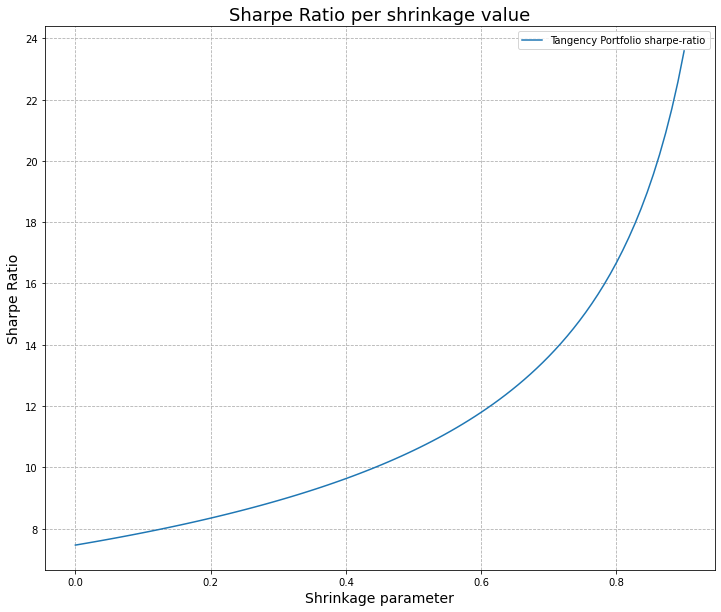

In [4]:
plt.figure(figsize=(12,10))

plt.plot(shrinkage, sharpe_ratio, label="Tangency Portfolio sharpe-ratio")

plt.title("Sharpe Ratio per shrinkage value", size=18)
plt.ylabel("Sharpe Ratio", size=14)
plt.xlabel("Shrinkage parameter", size=14)

plt.legend()
plt.grid(linestyle="--")

plt.show()

# Question: Shrinking the correlation matrix

I am quite certain I am doing something wrong when computing the adjusted (shrunk) correlation matrix $\Omega$. The final adjusted variance-covariance matrix is simply zero, which seems way off. Furthermore, the variance-covariance matrix is a diagonal matrix with only the diagonal being different from zero ~ like a diagonal matrix of variances.

**Paragraph from paper**

<div class="warning" style='padding:0.1em; background-color:#A0A0A0; color:#FFFFFF'>
<span>
<p style='margin-top:1em; text-align:center'>
<b>Calibration of Shrinkage Parameter</b></p>
<p style='margin-left:1em;'>
To see how the simple EPO works in practice, consider a shrinkage parameter $𝑤 ∈ [0,1]$. First, the offdiagonal correlation $\Omega_{ij}$ between any pair of assets $𝑖$ and $𝑗$ is replaced by $(1 − 𝑤)Ω_{ij}$, and then we
perform MVO using this modified variance-covariance matrix. 
That’s it! Note that this is very easy to do. 
When the EPO parameter is $𝑤 = 0$, there is no shrinkage, so this method yields the standard MVO. When
$𝑤 = 1$, then all correlations are set to zero, and the solution is essentially the same as not optimizing
(similar to standard Fama-French factors and even more similar to signal-weighted portfolios considered
in Asness, Moskowitz and Pedersen, 2013). With any shrinkage $𝑤 ∈ (0,1)$, we get somewhere in between
standard MVO and no optimizing, but in a way that works surprisingly well. To
How much shrinkage is needed? The simple answer is that this is an empirical question. We empirically
choose $𝑤$ out-of-sample as follows: each time period, we estimate what choice of $𝑤$ would have produced
the highest SR in the time period up until today, and then use this estimate in the next time period. In
several applications, $𝑤 = 75\%$ works well.
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'> <b>- Pedersen, Babu, Levine</b> <i>(Enhanced Portfolio Optimization, page 4, 2021)</i>
</p></span>
</div>


**Enhanced Porfolio optimization ~ paper**

---

*Variances of principal components ~ eigenvalues*

$$
\tilde{D} = (1 - \Phi) D + \Phi I
$$

* $\tilde{D}$: Adjusted diagonal matrix of eigenvalues (variance of principal component portfolios).
* $\Phi$: Degree of shrinkage, $\Phi \in [0,1]$.
* $I$: Identity matrix.

---

*Adjusted correlation matrix*

$$
\tilde{\Omega} = P \tilde{D} P^\intercal
$$

* $\tilde{\Omega}$: Adjusted (shrunk) correlation matrix.
* $P$: Matrix of eigenvectors, whose columns are principal components.
* $\tilde{D}$: Adjusted variances of principal components ~ eigenvalues.

---

*Adjusted variance-covariance matrix*

$$
\tilde{\Sigma} = \sigma \Omega \sigma
$$

* $\tilde{\Omega}$: Adjusted (shrunk) correlation matrix.
* $P$: Matrix of eigenvectors, whose columns are principal components.
* $\tilde{D}$: Adjusted variances of principal components ~ eigenvalues.

---

In [5]:
n = len(ret[0])
pca = PCA(n_components=n)
pc = pca.fit_transform(ret)

# eigenvalues and -vectors
eigenvalues = pca.explained_variance_ # eigenvalues
eigenvectors = pca.components_ # eigenvectors ~ PC# as rows

# inputs
Phi = 0.1
D = np.diag(eigenvalues)
I = np.identity(n)
P = eigenvectors.T
sigma = np.var(ret, axis=0)

In [6]:
print("Unadjusted diagonal matrix of eigenvalues")
D

Unadjusted diagonal matrix of eigenvalues


array([[0.00919614, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00128942, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00083378, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00045742, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00031945]])

In [7]:
D_adj = (1 - Phi) * D + Phi * I

print("Adjusted diagonal matrix of eigenvalues")
D_adj

Adjusted diagonal matrix of eigenvalues


array([[0.10827653, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.10116047, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.1007504 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.10041168, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.10028751]])

In [8]:
Omega = P * D_adj * P.T

print("Adjusted diagonal matrix of correlations")
np.round(Omega, 4)

Adjusted diagonal matrix of correlations


array([[ 0.0157,  0.    ,  0.    , -0.    ,  0.    ],
       [ 0.    ,  0.013 , -0.    ,  0.    , -0.    ],
       [ 0.    , -0.    ,  0.    , -0.    , -0.    ],
       [-0.    ,  0.    , -0.    ,  0.0005,  0.    ],
       [ 0.    , -0.    , -0.    ,  0.    ,  0.0204]])

In [17]:
Sigma_adj = np.outer(sigma, sigma) * Omega

print("Adjusted variance-covariance matrix")
np.round(Sigma_adj, 10)

Adjusted variance-covariance matrix


array([[ 4.16e-08,  0.00e+00,  0.00e+00, -0.00e+00,  0.00e+00],
       [ 0.00e+00,  5.78e-08, -0.00e+00,  0.00e+00, -0.00e+00],
       [ 0.00e+00, -0.00e+00,  0.00e+00, -0.00e+00, -0.00e+00],
       [-0.00e+00,  0.00e+00, -0.00e+00,  1.40e-09,  0.00e+00],
       [ 0.00e+00, -0.00e+00, -0.00e+00,  0.00e+00,  1.62e-07]])